# Deep Learning Course 5th Assignment

**Created by:** Szócska Miklós

This is the 5th assignment of the 'Deep Learning in Practice with Python and LUA' course from BME TMIT. The task was to run a hyperparameter optimization with at least 100 training runs, and analyze the results. I started from the notebook presented on the 12th  practice, the GitHub link can be found below. I used the Hyperas framework.

Starting code: [GitHub link](https://github.com/BME-SmartLab-Education/vitmav45/blob/master/12/hyperas_fashionmnist_pub.ipynb)

In [ ]:
# installing the Hyperas framework
# it is recommended to restart the runtime after
!pip3 install hyperas
!pip3 install hyperopt

In [62]:
# keras imports
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# numpy and pandas
import numpy as np
import pandas as pd

# data visualization packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# for automatic file download from the colab runtime
from google.colab import files

# hyperas imports
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

## Hyperparameter optimization

In this segment I created a simple convolution neural network with 3 convolutional blocks and 1 dense layer for classification. The convolutional blocks consist of two convolutional layers, a mac pooling layer, and a batch normalization layer. The dense layer also has a batch normalization layer after. I experimented with different kernel sizes and filter depths, batch normalization momentums, batch sizes and dense layer neuron counts. I ran random search multiple times and saved the results in .csv files. I then concatenated these files to form one big log file with 325 total training runs.

In [ ]:
# hyperas -> data loading
def data():
  # downloading the CIFAR-10 dataset
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  
  # number of classes
  num_classes = 10
  
  # one-hot encoding
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  
  # type conversion to float32
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  # normalization [0-1]
  x_train /= 255.0
  x_test /= 255.0
  
  return x_train, y_train, x_test, y_test

In [ ]:
# hyperas -> creating model
def create_model(x_train, y_train, x_test, y_test):
  # the choices
  filter_conv_1 = {{choice([32, 64])}}
  kernel_conv_1 = {{choice([3, 5])}}
  filter_conv_2 = {{choice([64, 128])}}
  kernel_conv_2 = {{choice([3, 5])}}
  filter_conv_3 = {{choice([128, 256])}}
  kernel_conv_3 = {{choice([3, 5])}}
  batchnorm_1 = {{uniform(0.7, 1.0)}}
  batchnorm_2 = {{uniform(0.7, 1.0)}}
  batchnorm_3 = {{uniform(0.7, 1.0)}}
  batchnorm_4 = {{uniform(0.7, 1.0)}}
  n_dense = {{choice([64, 128, 256])}}
  batch_size = {{choice([64, 128, 256])}}
  print('the model\'s hyperparameters: ', filter_conv_1, kernel_conv_1, filter_conv_2, kernel_conv_2, filter_conv_3, kernel_conv_3, batchnorm_1, batchnorm_2, batchnorm_3, batchnorm_4, n_dense, batch_size)

  # model definition with choices
  model = Sequential()
  model.add(Conv2D(filter_conv_1, (kernel_conv_1, kernel_conv_1), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(filter_conv_1, (kernel_conv_1, kernel_conv_1), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(momentum=batchnorm_1))
  model.add(Conv2D(filter_conv_2, (kernel_conv_2, kernel_conv_2), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filter_conv_2, (kernel_conv_2, kernel_conv_2), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(momentum=batchnorm_2))
  model.add(Conv2D(filter_conv_3, (kernel_conv_3, kernel_conv_3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(filter_conv_3, (kernel_conv_3, kernel_conv_3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(momentum=batchnorm_3))
  model.add(Flatten())
  model.add(Dense(n_dense, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization(momentum=batchnorm_4))
  model.add(Dense(10, activation='softmax'))

  # compiling model
  opt = Adam()
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  # early stopping callback
  callbacks = [EarlyStopping(monitor='val_accuracy', patience=7, verbose=0)]
    
  # model training
  result = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=50,
            verbose=2,
            validation_data=(x_test, y_test),
            callbacks=callbacks,
            shuffle=True)
    
  # saving the best validation accuracy
  best_val_acc = np.amax(result.history['val_accuracy']) 
  print('best val_acc:', best_val_acc)

  # logging
  with open('assignment-5-cifar-10-hyperas-log.csv', 'a') as csv_file:
    csv_file.write(str(filter_conv_1) + ';')
    csv_file.write(str(kernel_conv_1) + ';')
    csv_file.write(str(filter_conv_2) + ';')
    csv_file.write(str(kernel_conv_2) + ';')
    csv_file.write(str(filter_conv_3) + ';')
    csv_file.write(str(kernel_conv_3) + ';')
    csv_file.write(str(batchnorm_1) + ';')
    csv_file.write(str(batchnorm_2) + ';')
    csv_file.write(str(batchnorm_3) + ';')
    csv_file.write(str(batchnorm_4) + ';')
    csv_file.write(str(n_dense) + ';')
    csv_file.write(str(batch_size) + ';')
    csv_file.write(str(best_val_acc) + '\n')


  # negative val_acc, because the hyperopt package  minimalizes
  return {'loss': -best_val_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
# initializing log file
with open('assignment-5-cifar-10-hyperas-log.csv', 'w') as csv_file:
  csv_file.write('filter_conv_1' + ';')
  csv_file.write('kernel_conv_1' + ';')
  csv_file.write('filter_conv_2' + ';')
  csv_file.write('kernel_conv_2' + ';')
  csv_file.write('filter_conv_3' + ';')
  csv_file.write('kernel_conv_3' + ';')
  csv_file.write('batchnorm_1' + ';')
  csv_file.write('batchnorm_2' + ';')
  csv_file.write('batchnorm_3' + ';')
  csv_file.write('batchnorm_4' + ';')
  csv_file.write('n_dense' + ';')
  csv_file.write('batch_size' + ';')
  csv_file.write('best_val_acc' + '\n')

In [ ]:
# hyperparameter optimization
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=30,
                                          notebook_name='deep_assignment_05',
                                          trials=Trials())

>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    from keras.datasets import cifar10
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from google.colab import files
except:
    pass

try:
    import hyperas
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'filter_conv_1': hp.choice('filter_conv_1

In [ ]:
# automatic download of the log file after the finished hyperparameter optimization
files.download('assignment-5-cifar-10-hyperas-log.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results

In this segment I try to analyze the result of the hyperparameter optimization. The explanations will be under the plotted figures and not above the code cells.

In [138]:
# reading the log file into a DataFrame
df = pd.read_csv('assignment-5-cifar-10-hyperas-log.csv', ';')
df = df.drop('Unnamed: 0', axis=1)
df

,filter_conv_1,kernel_conv_1,filter_conv_2,kernel_conv_2,filter_conv_3,kernel_conv_3,batchnorm_1,batchnorm_2,batchnorm_3,batchnorm_4,n_dense,batch_size,best_val_acc
0,64,5,128,3,256,3,0.946853,0.719611,0.705346,0.953509,128,256,0.8225
1,32,3,64,3,256,5,0.849117,0.720297,0.989880,0.703332,256,64,0.8169
2,32,5,128,3,256,3,0.841000,0.890854,0.913427,0.868714,256,128,0.7992
3,32,3,64,5,256,5,0.765662,0.776903,0.736195,0.748075,128,128,0.8106
4,32,3,128,5,256,5,0.944272,0.938115,0.950928,0.985982,256,64,0.8353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,64,3,128,5,128,5,0.735875,0.786318,0.863996,0.892172,256,256,0.8253
321,64,3,128,5,128,5,0.784522,0.738435,0.795735,0.878337,256,256,0.8420
322,64,3,128,5,128,5,0.789569,0.754614,0.791121,0.919228,256,256,0.8175
323,64,3,128,5,128,5,0.770443,0.728492,0.786577,0.874608,256,256,0.8451


In [139]:
# convolutional block params count, we calculate two convolutional layers' params
# one convolutional layer's size is:
# (kernel_width * kernel_height * previous_output_depth + 1_for_bias) * filter_depth
df['conv_1_params'] = (df['kernel_conv_1']*df['kernel_conv_1']*3+1)*df['filter_conv_1'] + (df['kernel_conv_1']*df['kernel_conv_1']*df['filter_conv_1']+1)*df['filter_conv_1']
df['conv_2_params'] = (df['kernel_conv_2']*df['kernel_conv_2']*df['filter_conv_1']+1)*df['filter_conv_2'] + (df['kernel_conv_2']*df['kernel_conv_2']*df['filter_conv_2']+1)*df['filter_conv_2']
df['conv_3_params'] = (df['kernel_conv_3']*df['kernel_conv_3']*df['filter_conv_2']+1)*df['filter_conv_3'] + (df['kernel_conv_3']*df['kernel_conv_3']*df['filter_conv_3']+1)*df['filter_conv_3']

# fully connected layer param count
# the formula is:
# previous_layer_neurons * current_layer_neurons + 1 * current_layer_neurons
df['dense_params'] = 4 * 4 * df['filter_conv_3'] * df['n_dense'] + 1 * df['n_dense']
df['softmax_params'] = df['n_dense'] * 10 + 1 * 10
df['all_conv_params'] = df['conv_1_params'] + df['conv_2_params'] + df['conv_3_params']
df['all_dense_params'] = df['dense_params'] + df['softmax_params']

# all parameters count
# I didn't count the Batch Normalization layers' params but they are relatively small numbers compared to these
df['all_params'] = df['conv_1_params'] + df['conv_2_params'] + df['conv_3_params'] + df['dense_params'] + df['softmax_params']

In [140]:
# top 10 performing networks
df_best_10 = df.sort_values(by=['best_val_acc'], ascending=False).head(10)
df_best_10

,filter_conv_1,kernel_conv_1,filter_conv_2,kernel_conv_2,filter_conv_3,kernel_conv_3,batchnorm_1,batchnorm_2,batchnorm_3,batchnorm_4,n_dense,batch_size,best_val_acc,conv_1_params,conv_2_params,conv_3_params,dense_params,softmax_params,all_conv_params,all_dense_params,all_params
140,64,3,128,5,256,5,0.817945,0.910003,0.796394,0.909362,256,64,0.8527,38720,614656,2458112,1048832,2570,3111488,1051402,4162890
30,64,3,128,5,256,5,0.751351,0.732163,0.703829,0.927195,256,256,0.8521,38720,614656,2458112,1048832,2570,3111488,1051402,4162890
38,64,3,128,5,256,5,0.830596,0.770633,0.920921,0.891721,64,256,0.8515,38720,614656,2458112,262208,650,3111488,262858,3374346
46,64,3,128,3,256,3,0.751312,0.813946,0.751095,0.895024,128,128,0.8514,38720,221440,885248,524416,1290,1145408,525706,1671114
35,64,3,128,5,256,5,0.863792,0.702413,0.909437,0.982856,256,256,0.8504,38720,614656,2458112,1048832,2570,3111488,1051402,4162890
143,64,3,128,5,256,5,0.742647,0.842112,0.787236,0.951997,256,256,0.8496,38720,614656,2458112,1048832,2570,3111488,1051402,4162890
22,64,3,128,5,256,5,0.814118,0.748540,0.858846,0.972667,256,256,0.8491,38720,614656,2458112,1048832,2570,3111488,1051402,4162890
32,64,3,128,5,256,5,0.807059,0.719976,0.811122,0.877883,128,256,0.8476,38720,614656,2458112,524416,1290,3111488,525706,3637194
26,64,3,128,5,256,5,0.735131,0.799495,0.838826,0.921916,256,256,0.8470,38720,614656,2458112,1048832,2570,3111488,1051402,4162890
27,64,3,128,5,256,5,0.734492,0.701017,0.793039,0.934869,256,256,0.8465,38720,614656,2458112,1048832,2570,3111488,1051402,4162890


In [141]:
# bottom 10 performing networks
df_worst_10 = df.sort_values(by=['best_val_acc'], ascending=False).tail(10)
df_worst_10

,filter_conv_1,kernel_conv_1,filter_conv_2,kernel_conv_2,filter_conv_3,kernel_conv_3,batchnorm_1,batchnorm_2,batchnorm_3,batchnorm_4,n_dense,batch_size,best_val_acc,conv_1_params,conv_2_params,conv_3_params,dense_params,softmax_params,all_conv_params,all_dense_params,all_params
305,32,5,64,3,256,3,0.940772,0.885060,0.970006,0.858797,256,128,0.7828,28064,55424,737792,1048832,2570,821280,1051402,1872682
64,32,5,64,5,128,5,0.832037,0.966661,0.810593,0.815220,64,128,0.7816,28064,153728,614656,131136,650,796448,131786,928234
245,32,5,64,3,256,3,0.940772,0.885060,0.970006,0.858797,256,128,0.7799,28064,55424,737792,1048832,2570,821280,1051402,1872682
65,32,5,64,3,256,3,0.940772,0.885060,0.970006,0.858797,256,128,0.7790,28064,55424,737792,1048832,2570,821280,1051402,1872682
47,32,5,64,5,256,5,0.999658,0.732614,0.900835,0.951457,64,256,0.7781,28064,153728,2048512,262208,650,2230304,262858,2493162
184,32,5,64,5,128,5,0.832037,0.966661,0.810593,0.815220,64,128,0.7778,28064,153728,614656,131136,650,796448,131786,928234
210,64,5,128,3,128,3,0.978375,0.966128,0.761572,0.828016,256,256,0.7778,107328,221440,295168,524544,2570,623936,527114,1151050
215,32,5,64,3,256,3,0.940772,0.885060,0.970006,0.858797,256,128,0.7770,28064,55424,737792,1048832,2570,821280,1051402,1872682
125,32,5,64,3,256,3,0.940772,0.885060,0.970006,0.858797,256,128,0.7731,28064,55424,737792,1048832,2570,821280,1051402,1872682
60,64,5,128,3,128,3,0.978375,0.966128,0.761572,0.828016,256,256,0.7702,107328,221440,295168,524544,2570,623936,527114,1151050


In [142]:
# every network without the top and bottom 10 networks
df_rest = df.sort_values(by=['best_val_acc'], ascending=False).iloc[10:315]

We can take a look at the top 10 and the bottom 10 networks in terms of validation accuracy. We can see a trend that the best performing networks have deep convolutional filters, small kelners at the start of the network and bigger kernels at the later layers. It also seems that the bigger batch sizes and dense layer sizes are dominating the top. The batch normalization momentums seem to be in the upper half of the given range.

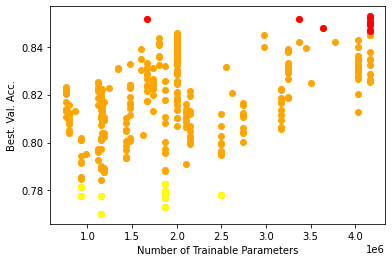

In [143]:
plt.scatter(x=df['all_params'], y=df['best_val_acc'], color='orange')
plt.scatter(x=df_best_10['all_params'], y=df_best_10['best_val_acc'], color='red')
plt.scatter(x=df_worst_10['all_params'], y=df_worst_10['best_val_acc'], color='yellow')

plt.xlabel('Number of Trainable Parameters')
plt.ylabel('Best. Val. Acc.')

plt.show()

It is obvious that with more trainable parameters the network learns better. We probably haven't reached the optimal number of parameters for the network.

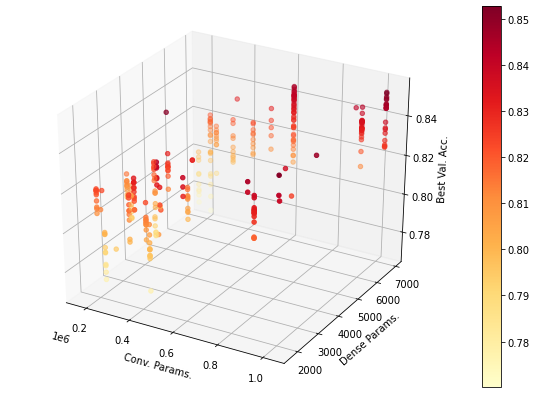

In [144]:
# all_conv_params   ---   all_dense_params
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df_net_size['all_conv_params'], df_net_size['all_dense_params'], df_net_size['best_val_acc'], c=df_net_size['best_val_acc'], cmap='YlOrRd')
ax.set_xlabel('Conv. Params.')
ax.set_ylabel('Dense Params.')
ax.set_zlabel('Best Val. Acc.')
fig.colorbar(p)
plt.show()

We can see that the convolution layers' parameters are more important for a succesful training, probably beacuse we are trying to classify image data. The more parameters in the dense layer help too.

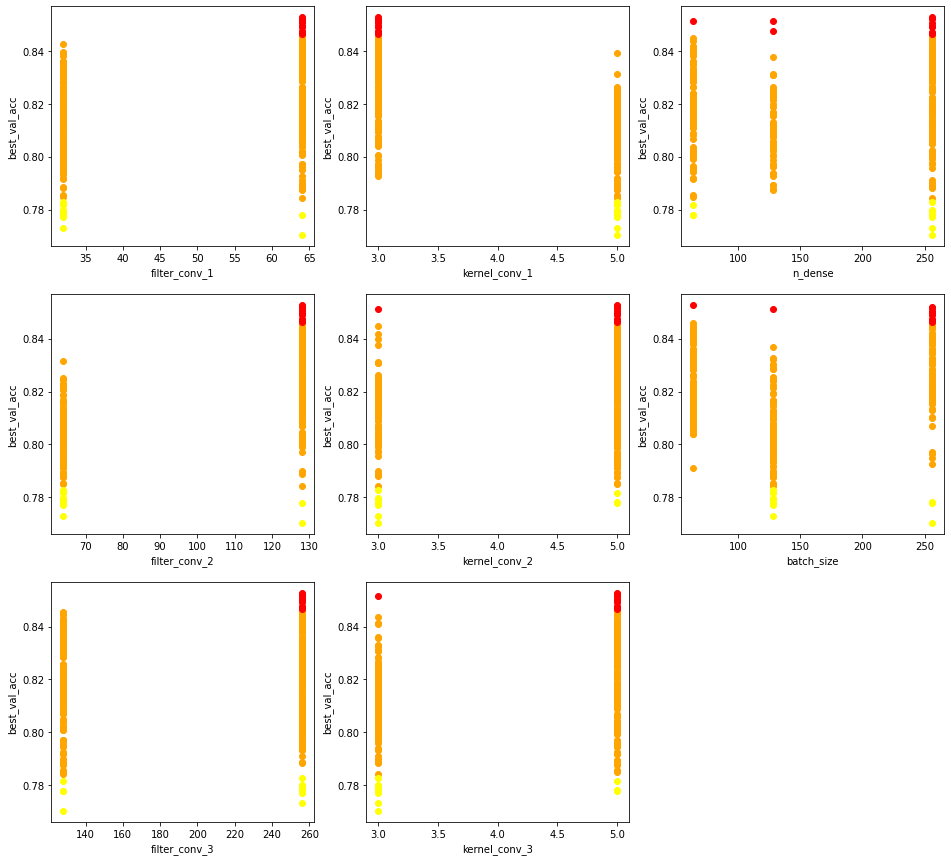

In [145]:
# categorical variables
fig = plt.figure(figsize=(16.0,15.0))
axes = fig.subplots(3, 3)
row, col = 0, 0
for hyperparam in ['filter_conv_1', 'filter_conv_2', 'filter_conv_3', 'kernel_conv_1', 'kernel_conv_2', 'kernel_conv_3', 'n_dense', 'batch_size']:
  axes[row,col].scatter(x=df_rest[hyperparam], y=df_rest['best_val_acc'], color='orange')
  axes[row,col].scatter(x=df_best_10[hyperparam], y=df_best_10['best_val_acc'], color='red')
  axes[row,col].scatter(x=df_worst_10[hyperparam], y=df_worst_10['best_val_acc'], color='yellow')
  axes[row,col].set(xlabel=hyperparam, ylabel='best_val_acc')
  row += 1
  if row > 2:
    row = 0
    col += 1

# the last subplot does not contain any plot so we hide it
axes[2,2].set_frame_on(False)
axes[2,2].set_axis_off()

plt.show()

Thes are the hyperparameters with only 2 or 3 possible values. We can see that the bigger filter depths always perform better, especially in the second convolutional block. What we can take away from the kernel size is that in the first block the smaller size is obviously better, in the third block the bigger is better. In the middle convolutional block we see a little more ambiguous result, but we can say that the bigger size seems to be the right choice. We cannot say much about the number of neurons in the dense layer. The middle option seems to never perform very bad nor very good. The other two options have wider scales in accuracy. We can pretty much say the same thing about the batch size options.

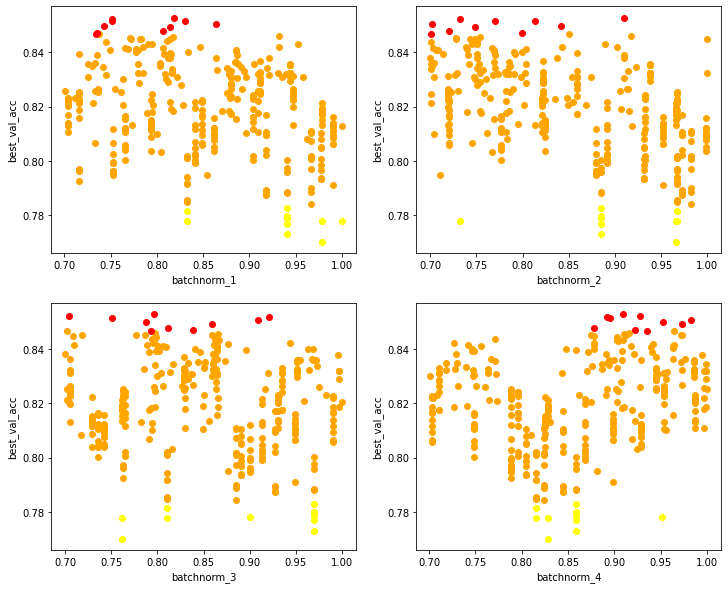

In [146]:
# continuous variables
fig = plt.figure(figsize=(12.0,10.0))
axes = fig.subplots(2, 2)
row, col = 0, 0
for hyperparam in ['batchnorm_1', 'batchnorm_2', 'batchnorm_3', 'batchnorm_4']:
  axes[row,col].scatter(x=df_rest[hyperparam], y=df_rest['best_val_acc'], color='orange')
  axes[row,col].scatter(x=df_best_10[hyperparam], y=df_best_10['best_val_acc'], color='red')
  axes[row,col].scatter(x=df_worst_10[hyperparam], y=df_worst_10['best_val_acc'], color='yellow')
  axes[row,col].set(xlabel=hyperparam, ylabel='best_val_acc')
  col += 1
  if col > 1:
    row, col = 1, 0

plt.show()

With the batch normalization layers we can determine some ranges.

|   layer   |min. momentum| max. momentum|
|-----------|-------------|--------------|
|BatchNorm 1|    0.72     |     0.86     |
|BatchNorm 2|  under 0.7  |     0.92     |
|BatchNorm 3|   0.75      |     0.90     |
|BatchNorm 4|   0.86      |     0.99     |

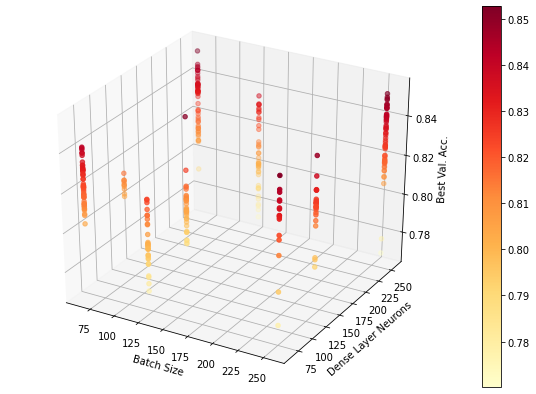

In [147]:
# batch_size  ---  n_dense
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df['batch_size'], df['n_dense'], df['best_val_acc'], c=df['best_val_acc'], cmap='YlOrRd')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Dense Layer Neurons')
ax.set_zlabel('Best Val. Acc.')
fig.colorbar(p)
plt.show()

If we look at the combination of batch size and the dense layer neuron we can see some more interesting results. It seems that we can choose some combination which perform better. If the batch size is 256, the dense layer is not that important, but if we choose 256 neurons we get the best result. We can also choose the lower 64 for batch size than we can have better performance with the 64 and 256 neuron count in the dense layer.

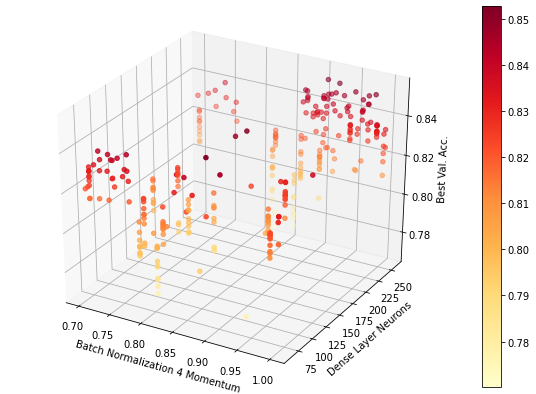

In [148]:
# batchnorm_4   ---   n_dense
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df['batchnorm_4'], df['n_dense'], df['best_val_acc'], c=df['best_val_acc'], cmap='YlOrRd')
ax.set_xlabel('Batch Normalization 4 Momentum')
ax.set_ylabel('Dense Layer Neurons')
ax.set_zlabel('Best Val. Acc.')
fig.colorbar(p)
plt.show()

If we inspect the dense layer neuron count and the 4th batch normalization layer momentum which comes after the dense layer, we can see some pretty results. If we choose a bigger neuron count at 256 we have to choose a bigger momentum around 0.95. If we choose 64 neurons we have to select a lower momentum value around 0.71.

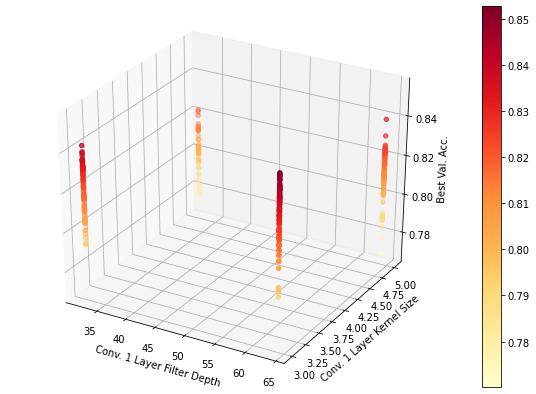

In [149]:
# filter_conv_1   ---   kernel_conv_1
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df['filter_conv_1'], df['kernel_conv_1'], df['best_val_acc'], c=df['best_val_acc'], cmap='YlOrRd')
ax.set_xlabel('Conv. 1 Layer Filter Depth')
ax.set_ylabel('Conv. 1 Layer Kernel Size')
ax.set_zlabel('Best Val. Acc.')
fig.colorbar(p)
plt.show()

In regards to the 1st convolutional block, we can see clearly that we have to choose 64 filter depth and 3 kernel size.

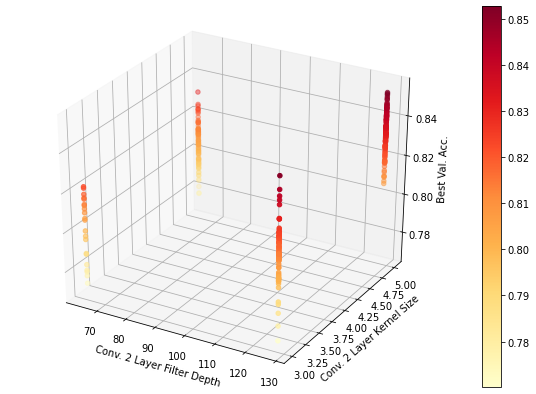

In [150]:
# filter_conv_2   ---   kernel_conv_2
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df['filter_conv_2'], df['kernel_conv_2'], df['best_val_acc'], c=df['best_val_acc'], cmap='YlOrRd')
ax.set_xlabel('Conv. 2 Layer Filter Depth')
ax.set_ylabel('Conv. 2 Layer Kernel Size')
ax.set_zlabel('Best Val. Acc.')
fig.colorbar(p)
plt.show()

In the 2nd convolutional block the clear winner is 5 kernel size and 128 filter depth.

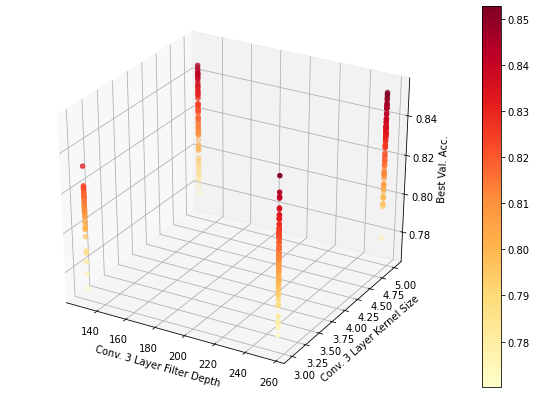

In [151]:
# filter_conv_3   ---   kernel_conv_3
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df['filter_conv_3'], df['kernel_conv_3'], df['best_val_acc'], c=df['best_val_acc'], cmap='YlOrRd')
ax.set_xlabel('Conv. 3 Layer Filter Depth')
ax.set_ylabel('Conv. 3 Layer Kernel Size')
ax.set_zlabel('Best Val. Acc.')
fig.colorbar(p)
plt.show()

The choice is bit more difficult at the 3rd convolutional block, because kernel size 3 and filter depth 256 are similar in terms of performance to kernel size 5 and filter depth 128, but the best option seems to be kernel size 5 and filter depth 256.

In [152]:
min_max_pct = (max(df['best_val_acc']) - min(df['best_val_acc'])) * 100
print('Validation accuracy difference between best and worst model: {:.2f}%'.format(min_max_pct))

Validation accuracy difference between best and worst model: 8.25%


In conclusion we can say that we won around 4% in validation accuracy from an average performing model.

The best parameters are:

|hyperparameter|value|
|--------------|-----|
|Conv1 Kernel Size|3|
|Conv1 Filter Depth|64|
|Conv2 Kernel Size|5|
|Conv2 Filter Depth|128|
|Conv3 Kernel Size|5|
|Conv3 Filter Depth|256|
|BatchNorm1|0.81|
|BatchNorm2|0.75|
|BatchNorm3|0.80|
|BatchNorm4|0.95|
|Dense Layer Neurons|256|
|Batch Size|256|

If we tried out more parameters and had a bigger number of runs, we could calibrate the best value more for these hyperparameters and probably improve a few percentages too.